<p style="align: center;"><img src="https://raw.githubusercontent.com/dimkablin/SegmentationSM/master/src/logo2.jpg", width=550, height=300></p>

<h1 style="text-align: center;"><b>Backend SM</b></h1>
<h2 style="text-align: center;"><b>Поиск архитекутуры для сегментации объекта для проекта SM </b></h2>

In [2]:
import os
from LookGenerator.config.config import DatasetConfig

config = DatasetConfig(os.environ)
config.show_details()

DATASET_DIR
BACKGROUND_DATASET


In [3]:
print(config.BACKGROUND_DATASET, config.DATASET_DIR)

C:\Users\dimka\PycharmProjects\data\background C:\Users\dimka\PycharmProjects\data\zalando-hd-resized\train


## Инициализируем датасет и dataloader

In [4]:
from torchvision.transforms import ToTensor, ToPILImage, PILToTensor
import torch
import os
import numpy as np
from typing import Tuple
import random

from PIL import Image
from torch.utils.data import Dataset

Напишем датасет, который будет в себе хранить названия всех файлов и загружать их в методе \_\_getitem__()

In [5]:
class OblDataset(Dataset):
    """ Dataset for Segmentation upper body """

    def __init__(self,
                 image_root: str,
                 mask_root: str,
                 mask_layer: int = 0,
                 image_extension="jpg",
                 transform_input=None,
                 transform_output=None,
                 augment=None):
        """
        Args:
            image_root (str) : path to images
            mask_root (str) : images directory name
            image_extension (str) : extension of any file
        """

        super().__init__()

        self.image_root = image_root
        self.mask_root = mask_root
        self.mask_layer = mask_layer
        self.image_extension = image_extension

        self.transform_input = transform_input
        self.transform_output = transform_output
        self.augment = augment

        names_of_files = os.listdir(self.image_root)
        self._files_list = [name.split('.')[0] for name in names_of_files]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Opening image by index that considered self.names_of_files variable

        Args:
            idx: The index of data sample

        Returns:
            Return torch.Tensor that represent image
                   torch.Tensor that represent mask
        """

        _image = Image.open(os.path.join(
                self.image_root,
                self._files_list[idx])
                    + "." + self.image_extension
            )

        _mask = Image.open(os.path.join(
                self.mask_root,
                self._files_list[idx])
                    + "." + self.image_extension
            )


        _image = PILToTensor()(_image)
        _mask = PILToTensor()(_mask)

        _mask = torch.where(_mask[0] == self.mask_layer, 1, 0)

        if self.augment:
            transformed = self.augment(image=_image,
                                       mask=_mask)
            _image = transformed['image']
            _mask = transformed['mask']

        if self.transform_input:
            _image = self.transform_input(_image)

        if self.transform_output:
            _mask = self.transform_output(_mask)

        return _image, _mask

    def __get_files_list__(self):
        """
        Returning list of file

        Returns:
            list with names of files
        """

        return self._files_list

    def __len__(self):
        """
        Return count of files

        Return:
            length of self._files_list
        """

        return len(self._files_list)


Передадим ему путь к исходным фотографиям X и маске Y

In [6]:
size = (256, 1092)

imageDataset = OblDataset(image_root=os.path.join(config.DATASET_DIR, "image"),
                          mask_root=os.path.join(config.DATASET_DIR, "agnostic-v3.2"),
                          mask_layer=128,
                          image_extension="jpg")


Проверим его корректность работы и выведем парочку

In [7]:
import matplotlib.pyplot as plt

def _print(image, mask):
    fig = plt.figure(figsize=(20, 14))

    fig.add_subplot( 1, 2, 1)
    plt.imshow(ToPILImage()(image))

    fig.add_subplot( 1, 2, 2)
    plt.imshow(mask, cmap='gray')

In [8]:
image, mask = imageDataset.__getitem__(232)
print(image.size(), mask.size())

torch.Size([3, 1024, 768]) torch.Size([1024, 768])


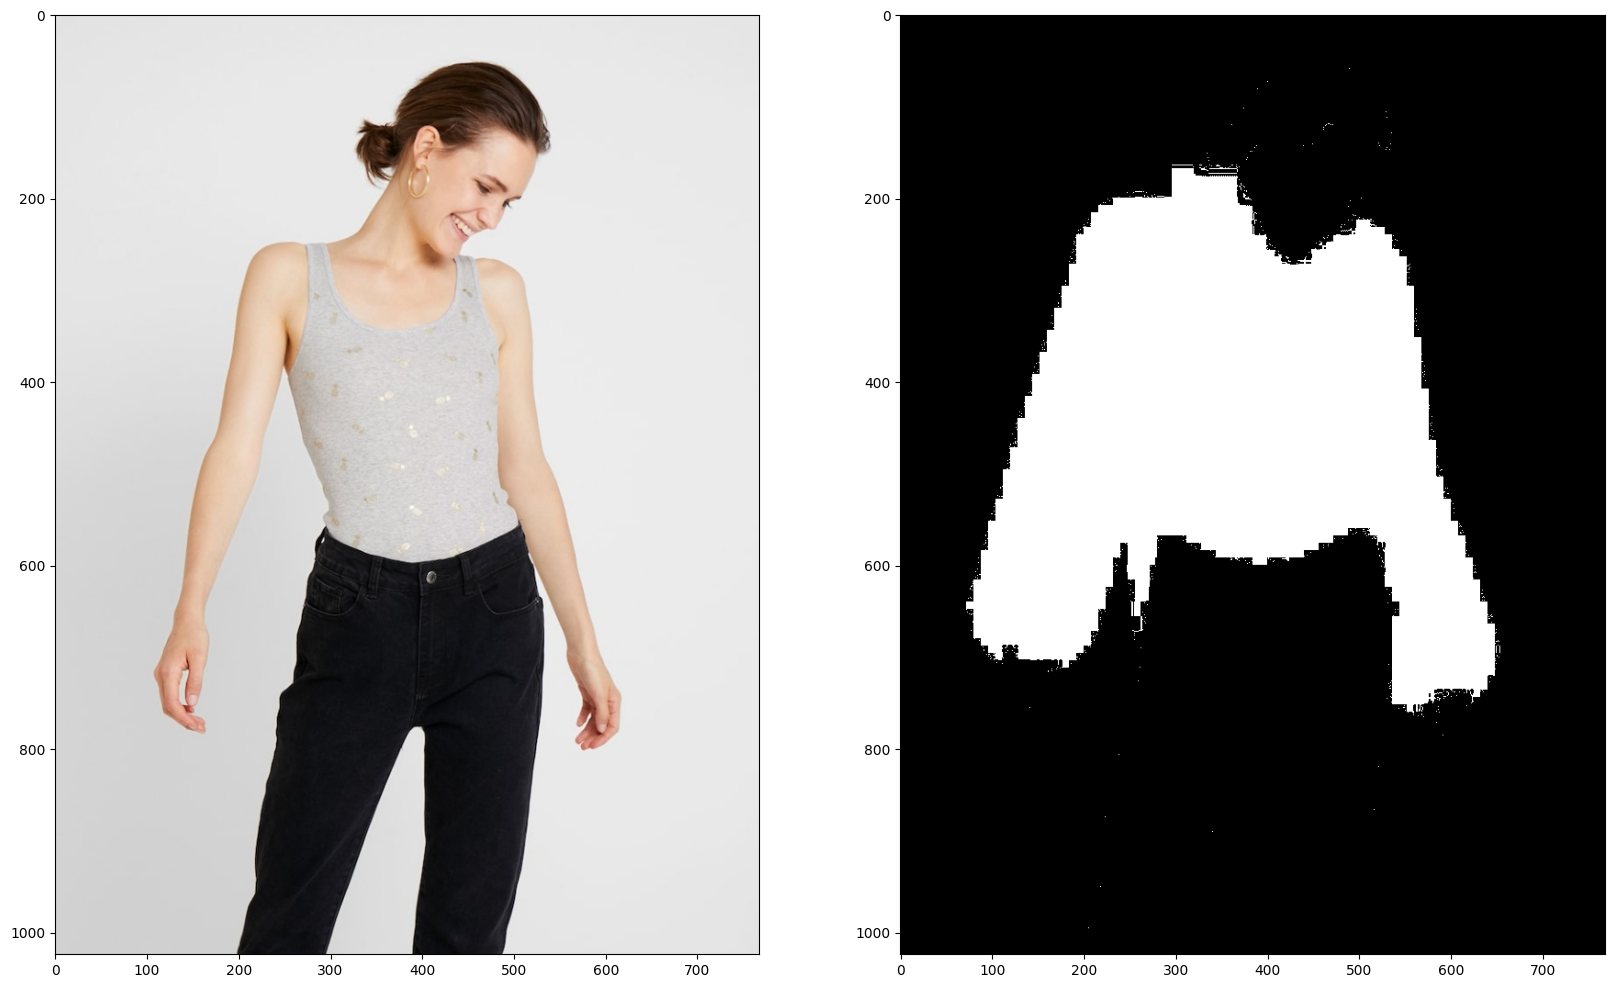

In [9]:
_print(image, mask)

Поделим датасет на тренировочную, валидационную и тестовую

In [10]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.5 * len(imageDataset))
val_size = int(0.25 * len(imageDataset))
test_size = len(imageDataset) - train_size - val_size

print(train_size, val_size, test_size)

5823 2911 2913


In [11]:
train_dataset, val_dataset, test_dataset = random_split(imageDataset, [train_size, val_size, test_size])

batch_size = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
dataloaders = {'train' : train_dataloader, 'val' : val_dataloader}

Попробуем воспользоваться CUDA

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [14]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

In [15]:
!nvidia-smi

Fri May  5 22:29:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8                2W /  N/A|    187MiB /  4096MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Реализируем основной цикл обучения

Однако сначала пропишем основную метрику

In [16]:
def iou_func(outputs: torch.Tensor, labels: torch.Tensor, smooth: float = 1e-7):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()

    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    return (intersection + smooth) / (union + smooth)

Цикл обучения

In [17]:
import os
import time
from IPython.display import clear_output

In [ ]:
def train(model, optim, loss_fn, epochs, dataloaders, device):
    log  = "\nEpoch {ep:03d} has done in {time:0.1f} train_iou: {t_iou:0.4f} val_iou: {v_iou:0.4f}"
    loss_history = {'train': [], 'val': []}
    iou_history = {'train': [], 'val': []}
    time_history = []

    for epoch in range(epochs):
        since = time.time()
        print("{}/{}".format(epoch+1, epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_iou = 0

            for x_batch, y_batch in dataloaders[phase]:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optim.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(x_batch)
                    # y_pred = torch.sigmoid(y_pred) # if we do not have activation func in model

                    loss = loss_fn(y_batch, y_pred)

                    if phase == 'train':
                        loss.backward()
                        optim.ztep()

                running_loss += loss.detach().item() * x_batch.size(0)

                y_pred = torch.where(y_pred > 0.5, 1, 0)
                running_iou += iou_func(y_batch, y_pred).mean().item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])

            loss_history[phase].append(epoch_loss)
            iou_history[phase].appen(epoch_iou)

            # Выведем немного статистики на валидации
            if phase == 'val':
                y_hat = y_pred.detach().cpu()

                clear_output(wait = True)
                for k in range(6):
                    plt.subplot(2, 6, k+1)
                    plt.imshow(np.rollaxis(x_batch[k].cpu().numpy(), 0, 3), cmap='gray')
                    plt.title('Real')
                    plt.axis('off')

                    plt.subplot(2, 6, k+7)
                    plt.imshow(y_hat[k, 0], cmap='gray')
                    plt.title('output')
                    plt.axis('off')
                plt.suptitle("Epoch: %d / %d Loss: %f IOU: %f" % (epoch+1, epochs, epoch_loss, epoch_iou))
                plt.show()

            # clear cuda
            x_batch.cpu(), y_batch.cpu()
            y_pred.cpu(), loss.cpu()

            time_history.append(time.time() - since)

            print(log.format(ep=epoch+1,
                             time=time_history[-1],
                             t_iou=iou_history['train'][-1],
                             v_iou=iou_history['val'][-1]))

    stat = loss_history, iou_history, time_history

    return stat

# Architectures
## 1. our Unet

## 2. SegNet

## 3. a few Unet's arhc